In [373]:
import torch.nn as nn 
import torch
from sklearn.datasets import make_moons
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange
from intvalpy import lineqs


from src import functions
from src import trainer
from src import models
from src import utils

import matplotlib.pyplot as plt
import matplotlib
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection


# Useful function to convert tensors to numpy arrays
def to_np(x):
    return x.cpu().detach().numpy()

## Data

In [374]:
# Set data function
data = utils.DataGenerator# Could be 'convex' or 'franke'

x, y = data.convex()
xt, yt = torch.tensor(x, dtype=torch.float), torch.tensor(y, dtype=torch.float)

In [375]:
# print shapes
print(f"x shape: {x.shape}, y shape: {y.shape}")


x shape: (10000, 2), y shape: (10000, 1)


In [376]:
def visualize_data(x, y):
    # plot in 3d
    fig = plt.figure(figsize=(20, 10))
    ax = fig.add_subplot(121, projection='3d')
    surface = ax.plot_trisurf(x[:, 0], x[:, 1], y.flatten(), cmap='viridis', edgecolor='none')
    ax = fig.add_subplot(122)
    scat = ax.scatter(x[:,0], x[:,1], c=y, cmap='viridis')
    # colorbar for the scatter plot
    cbar = plt.colorbar(scat, ax=ax)
    cbar.set_label('Target Value')
    plt.title('3D Scatter Plot of Generated Data')
    plt.show()

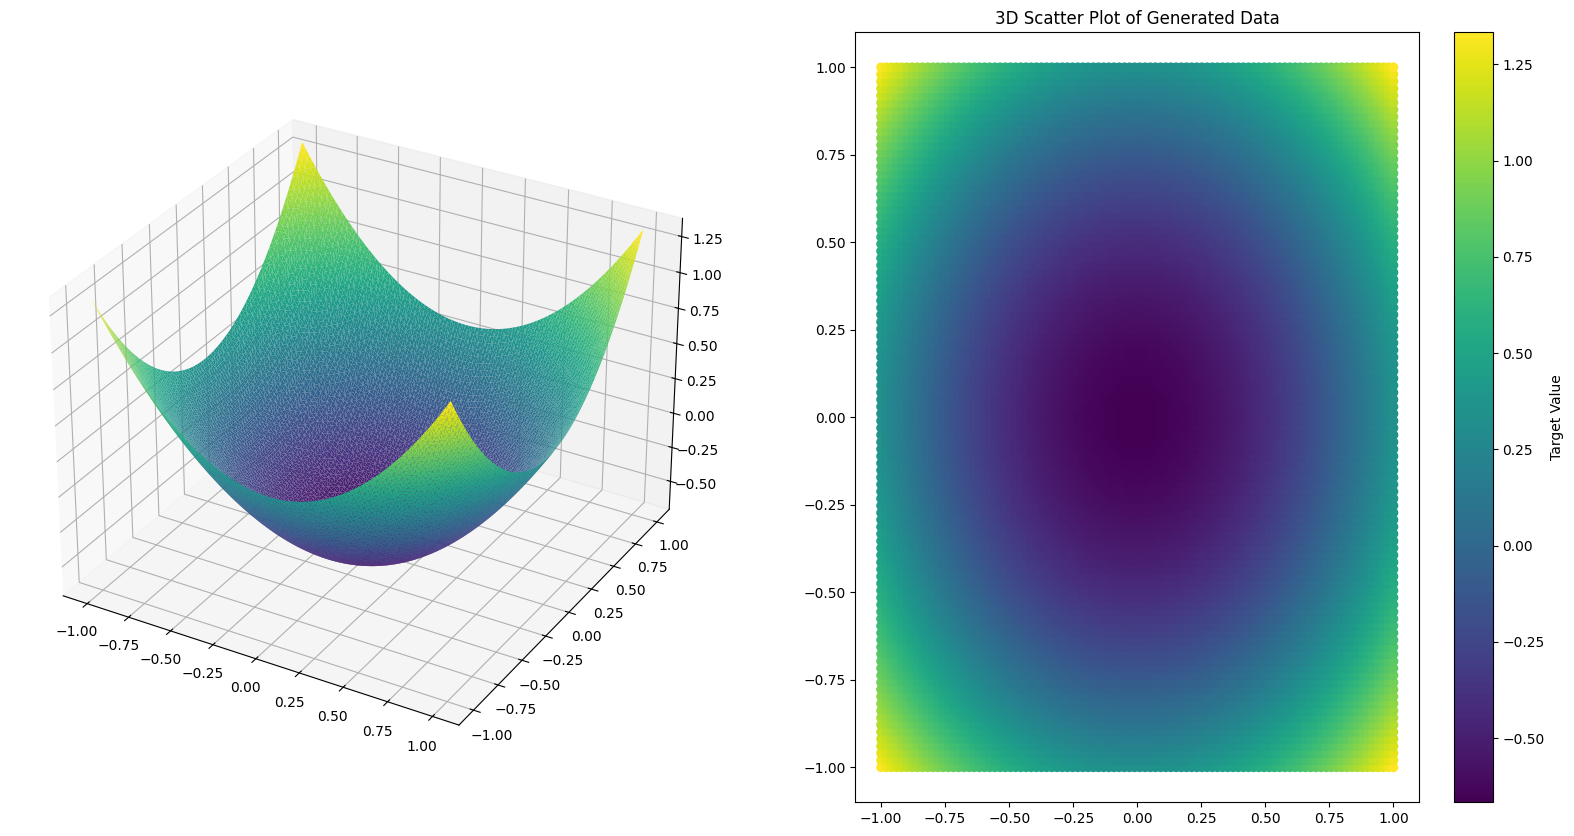

In [377]:
visualize_data(x, y)

100%|██████████| 2500/2500 [00:05<00:00, 472.92it/s]


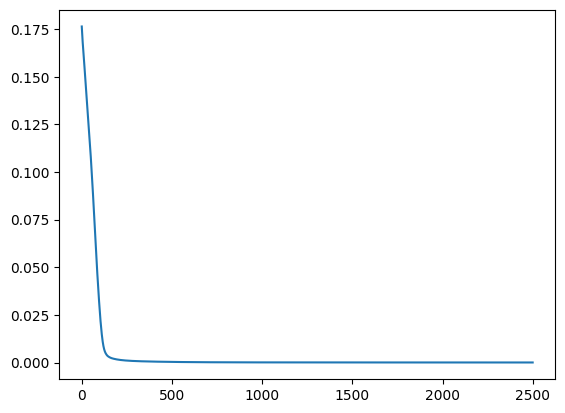

In [378]:
# Train model

EPOCHS = 2500
criterion = nn.MSELoss()

model = utils.NeuralNet(input_size=2, num_classes=1, hidden_sizes=[25,25])
optimizer = torch.optim.Adam(model.parameters())
losses = []

for epoch in trange(EPOCHS):
    model.train()
    optimizer.zero_grad()

    out = model(xt)
    loss = criterion(out, yt)
    loss.backward()
    losses.append(loss.item())
    optimizer.step()

    optimizer.zero_grad()

plt.figure(1)
plt.plot(losses)
plt.show()

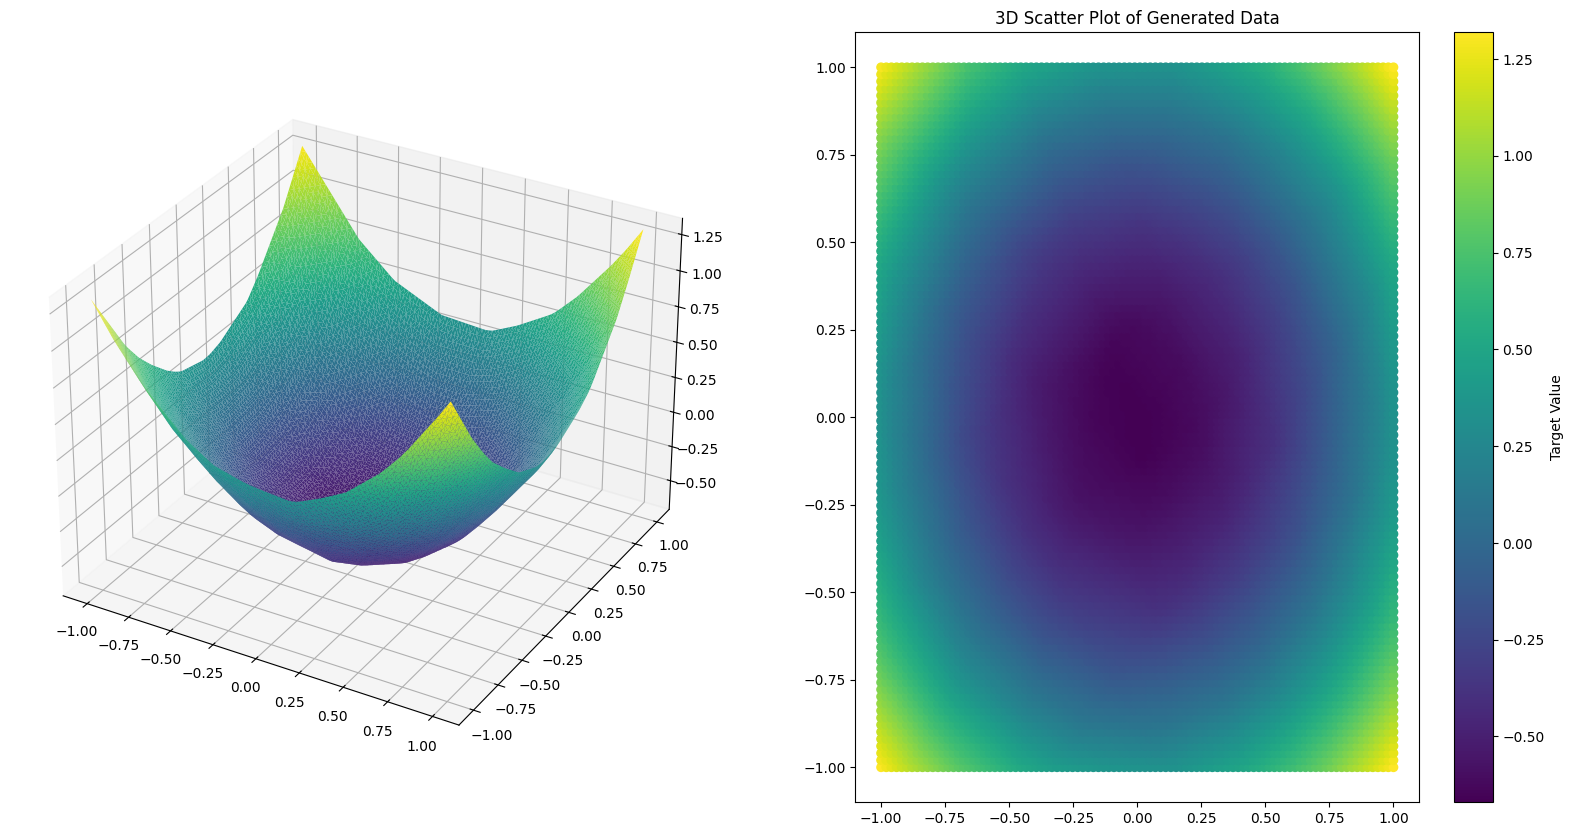

In [379]:
visualize_data(to_np(xt), to_np(out))

In [380]:
model.eval()

NeuralNet(
  (l1): Linear(in_features=2, out_features=25, bias=True)
  (relu1): ReLU()
  (l2): Linear(in_features=25, out_features=25, bias=True)
  (relu2): ReLU()
  (l3): Linear(in_features=25, out_features=1, bias=True)
)

Random sample:
  [[ 0.7979798 ]
 [-0.75757575]]
Polytope no 100
Polytope no 200
Polytope no 300
Polytope no 400
Polytope no 500
Polytope no 600
Polytope no 700
Polytope no 800
Polytope no 900
Polytope no 1000
Polytope no 1100
Polytope no 1200
Polytope no 1300
Found 12186 vertices
Bound: 16384
Counter: 14


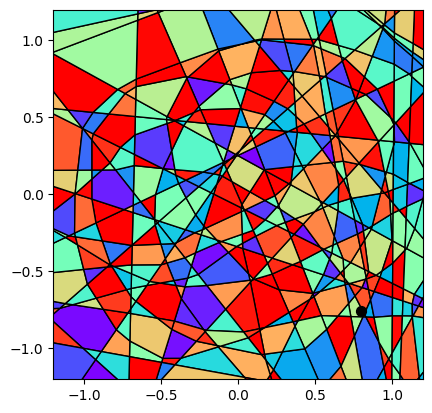

The number of polytopes within the boundaries is: 6215


In [381]:
np.random.seed(10)
rand_idx = np.random.randint(0, xt.shape[0])
random_sample = to_np(xt[rand_idx].unsqueeze(0).T)
print("Random sample:\n ", random_sample)

A_random_sample, c_random_sample = functions.get_inequalities(model,random_sample,return_bit_vec_list=False, input_dimension=2 )
        
indexes_for_active_bits_random_sample, stats = functions.active_bits_index_2 (A_random_sample[0],c_random_sample[0].reshape(-1) )

random_sample_bit_vector_list = functions.bit_vector_from_relus(model, random_sample.reshape(-1,1), get_unique_bit_vectors_only=True)
random_sample_bit_vector=np.vstack(random_sample_bit_vector_list[0])

polytope_list, active_bit_count_list  = functions.get_polytope_list(random_sample_bit_vector, indexes_for_active_bits_random_sample, input_dimension=2, model=model)

bit_string_list_from_alg = polytope_list

def divide_column_vector(column_vector):
    return np.array_split(column_vector, 2)

list_of_lists_of_column_vectors_alg = [divide_column_vector(column_vector) for column_vector in bit_string_list_from_alg]

A_alg, c_alg = functions.get_inequalities(model,list_of_lists_of_column_vectors_alg, is_input_sample=False,return_bit_vec_list=False, input_dimension=2)
len(A_alg)


verticles_list_alg = []

bound = 2


def find_verticles(A, c):
    # Find the boundaries of the polytope defined by Ax <= c
    # This is a placeholder function; you may need to implement a more robust method
    for A, c in zip (A_alg, c_alg):
        verticles = lineqs(-A, -c, title='Solution', color='red', save=False, show=False, bounds = [[-bound, -bound], [bound, bound]])
        verticles_list_alg.append(verticles)
    return verticles_list_alg

counter = 1
c_max = 500
while counter <= c_max:
    try:
        verticles_list_alg = find_verticles(A_alg, c_alg)
        print(f"Found {len(verticles_list_alg)} vertices\nBound: {bound}\nCounter: {counter}")
        break
    except IndexError:
        counter += 1
        bound = 2**counter
    if counter == c_max:
        print(f"Failed to find vertices after {c_max} attempts. Last bound was: {bound:.2e}")


bound *= 1.1
bound = 1.2

fig = plt.figure()
ax = fig.add_subplot(111, aspect='equal')
patches = []
num_polygons = len(verticles_list_alg)
colors = [np.random.randint(1, 300) for i in range(num_polygons)]
cmap = matplotlib.colormaps['rainbow']

polytopes_within_boundaries = 0  # Counter for polytopes within boundaries

for i in range(num_polygons):
    vertices_i = verticles_list_alg[i]
    
    # Check if any vertex falls within the boundaries
    vertices_within_boundaries = any(-bound <= coord[0] <= bound and -bound <= coord[1] <= bound for coord in vertices_i)
#     clipped_vertices = clip_vertices(vertices_i.tolist(),bound)
    if vertices_within_boundaries:
        polygon = Polygon(xy=vertices_i,
                          closed=True,
                          facecolor=cmap(colors[i]),
                          edgecolor='black',
                        #   label=np.transpose(bit_string_list_from_alg[i])[0],
                         )
        ax.add_patch(polygon)
    
        patches.append(polygon)
        
        polytopes_within_boundaries += 1

        
        

ax.set_xlim([-bound, bound])
ax.set_ylim([-bound, bound])
# Show random sample point
ax.scatter(random_sample[0], random_sample[1], color='black', s=50, label='Random Sample', zorder=5)

p = PatchCollection(patches, cmap=matplotlib.cm.gist_rainbow, alpha=0.8)
# np.random.seed(10)
colors = [np.random.randint(1, 1000) for i in range(len(patches))]
plt.show()

print(f"The number of polytopes within the boundaries is: {polytopes_within_boundaries}")
